#### Set data

In [1]:
import numpy as np
import pandas as pd

# Set the random seed for reproducibility
np.random.seed(0)

# Load data
# data = np.load('../data/forr_rand_fns_n4_change_basis.npz')
# data = np.load('../data/forr_rand_fns_n6_change_basis.npz')
data = np.load('../data/forr_rand_fns_n8_change_basis.npz')

N = data['forr_f'].shape[2]

# Create training and testing data
x_train = np.zeros(data['forr_f'].shape)
x_test = np.zeros(data['forr_f'].shape)
y_train = np.zeros(data['forr_f'].shape[0])
y_test = np.zeros(data['forr_f'].shape[0])
for i in range(0, 25):
    # Training data
    x_train[i, :, :] = data["forr_f"][i, :, :]
    y_train[i] = 1
    x_train[i+25, :, :] = data["rand_f"][i, :, :]
    y_train[i+25] = 0
    # Test data
    x_test[i, :, :] = data["forr_f"][i+25, :, :]
    y_test[i] = 1
    x_test[i+25, :, :] = data["rand_f"][i+25, :, :]
    y_test[i+25] = 0

###############################################################################

# # Create random binary vectors for training
# x_train = np.random.randint(0, 2, (1000, 2, 10))

# # Create random binary vectors for testing
# x_test = np.random.randint(0, 2, (100, 2, 10))

# # Create binary labels for training and testing
# # In this example, a pair is labeled 1 if the two vectors are equal, and 0 otherwise
# y_train = np.all(x_train[:, 0] == x_train[:, 1], axis=1)
# y_test = np.all(x_test[:, 0] == x_test[:, 1], axis=1)

#### Build the model

In [2]:
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPooling2D
from tensorflow import keras as tfk

def euclidean_distance(vects):
    """
    Calculates the Euclidean distance between two vectors.

    Args:
        vects: A tuple of two vectors (x, y).

    Returns:
        The Euclidean distance between the two vectors.
    """
    x, y = vects
    return tfk.backend.sqrt(tfk.backend.maximum(tfk.backend.sum(tfk.backend.square(x - y), axis=1, keepdims=True), tfk.backend.epsilon()))

def eucl_dist_output_shape(shapes):
    """
    Calculates the output shape of the Euclidean distance layer.

    Parameters:
    shapes (tuple): A tuple containing the shapes of the input tensors.

    Returns:
    tuple: A tuple representing the output shape of the Euclidean distance layer.
        The first dimension is the batch size, and the second dimension is 1.
    """
    shape1, shape2 = shapes
    return (shape1[0], 1)

def create_base_network(input_shape):
    """
    Creates a base network for a neural network model.

    Parameters:
    input_shape (tuple): The shape of the input data.

    Returns:
    keras.Model: The base network model.
    """
    input = Input(shape=input_shape)
    # x = Conv2D(32, (3, 3), activation='relu')(input)
    # x = MaxPooling2D(pool_size=(2, 2))(x)
    # x = Conv2D(64, (3, 3), activation='relu')(x)
    # x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x) # use activation='sigmoid' if gradient-based optimization gives problems
    # x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    # x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)

# Create the base network
base_network = create_base_network((N,))

# Create the left input and point to the base network
input_a = Input(shape=(N,))
vect_output_a = base_network(input_a)

# Create the right input and point to the base network
input_b = Input(shape=(N,))
vect_output_b = base_network(input_b)

# Measure the similarity of the two vector outputs
output = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

# Specify the inputs and output of the model
model = Model([input_a, input_b], output)

# Compile the model
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

# Save the weights of the model for easier resetting
model.save_weights('model.weights.h5')

2024-06-07 14:33:13.115407: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 14:33:18.455064: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Run model

In [5]:
# Reshape the data to fit the network input (samples, vector)
x_train_1 = x_train[:, 0].reshape(-1, N)
x_train_2 = x_train[:, 1].reshape(-1, N)
x_test_1 = x_test[:, 0].reshape(-1, N)
x_test_2 = x_test[:, 1].reshape(-1, N)

# Train the model and store the history into results_raw
history = model.fit([x_train_1, x_train_2], y_train, batch_size=128, epochs=100, validation_data=([x_test_1, x_test_2], y_test))

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.5000 - loss: 3.9120 - val_accuracy: 0.5000 - val_loss: 4.2535
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.5000 - loss: 2.3818 - val_accuracy: 0.5000 - val_loss: 3.4553
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.5000 - loss: 1.4381 - val_accuracy: 0.5000 - val_loss: 2.8345
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.5000 - loss: 0.8662 - val_accuracy: 0.5000 - val_loss: 2.3577
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.5000 - loss: 0.5356 - val_accuracy: 0.5000 - val_loss: 1.9909
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.5000 - loss: 0.3534 - val_accuracy: 0.5000 - val_loss: 1.7024
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.5000 - loss: 0.2545 - val_accuracy: 0.5000 - val_loss: 1.4741
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.5000 - loss: 0.1984 - val_accuracy: 0.5000 - v

#### Plot

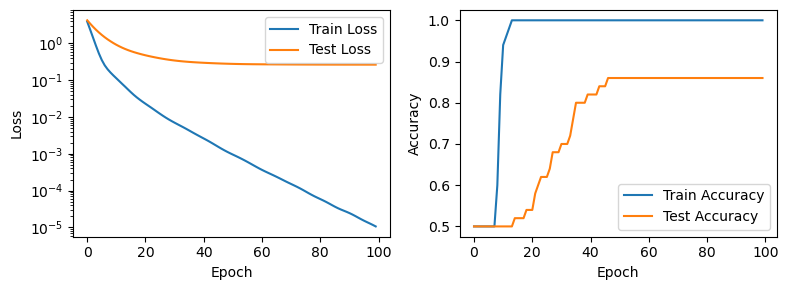

In [6]:
import matplotlib.pyplot as plt

# Plot the loss
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.semilogy(history.history['loss'], label='Train Loss')
plt.semilogy(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()